# 02. PyTorch Neural Network Classification

먼저 분류 문제가 무엇일까?

분류 문제란 무언가가 어떤 범주(클래스)에 속하는지 에측하는 문제이다. <br>
예) 이 이메일은 스팸인가 아닌가? / 이 사진은 사람인가 동물인가?

**분류 문제 유형**

1. 이진 분류(Binary Classification) : 두 가지 중 하나를 예측
2. 다중 클래스 분류(Multi-class classification) : 여러 클래스 중 하나를 예측
3. 다중 레이블 분류(Multi-label classification) : 여러 클래스를 동시에 예측 가능<br>
다중 클래스와 다중 레이블의 차이 -> 여러 레이블을 가질 수 있음, 하나의 클래스만 가능함

## 목차

0. classification neural network Architecture 소개
1. 이진 분류용 데이터 준비
2. PyTorch Classification 모델 구성
3. 모델 훈련
4. 추론
5. 모델 개선
6. 비선형선 개념
7. 비선형 함수 재현
8. 다중 클래스 분류 실습


## 0. 분류용 뉴럴 네트워크의 구조

뉴럴 네트워크에서 사용되는 하이퍼파라미터 

- input layer shape(입력층 형태) : 입력 특성 수와 동일
- hidden layer(은닉층 개수) : 최소 하나 이상
- neurons per hidden layer(은닉층의 뉴런 수) : 일반적으로 10 ~ 512개
- output layer shape(출력층 형태) : 1(0 또는 1의 확률로 출력) -> 클래스의 수만큼
- hidden layer activation function(은닉층 활성화 함수) : ReLU, Leakly ReLU, tanh ...
- output activation function(출력층 활성화 함수) : 이진 분류는 sigmoid, 다중 클래스는 softmax
- loss function(손실함수) : 이진 분류는 이진크로스엔트로피(torch.nn.BCELoss), 다중 클래스는 크로스엔트로피(torch.CrossEntropyLoss)
- optimizer(옵티마이저) : SGD, Adam 등등 torch.optim

## 1. 이진 분류용 데이터 준비

이번 실습에서 사용할 이진 분류용 데이터는 서로 다른 색상의 두개의 원형 데이터(make_circles() 이용)

(make_circles() : 두개의 동심원 형태로 데이터를 생성하는 함수, noise 파라미터를 조절해서 데이터의 난이도 조절)

In [9]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

print(f"First 5 X features: \n{X[:5]}\n")
print(f"First 5 y labels:\n{y[:5]}")

First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [17]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y
                       })
circles.head()
print(f"\n {circles.label.value_counts()}")


 label
1    500
0    500
Name: count, dtype: int64


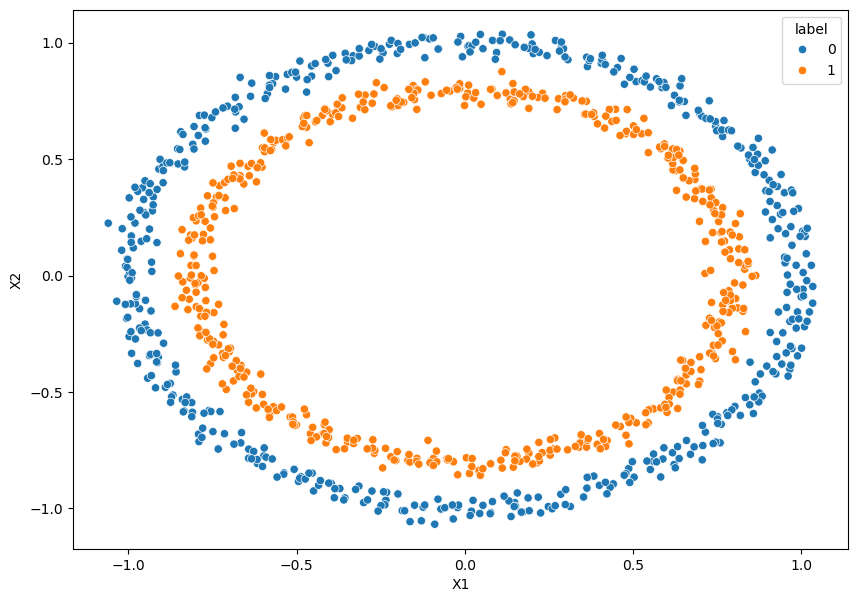

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.scatterplot(x="X1", y="X2", hue="label", data=circles)
plt.show()

### 1.1 인풋 & 아웃풋 데이터 Shape 확인하기

딥러닝에서 가장 흔한 오류 중 하나는 텐서의 shape error이다. 

항상 이 shape을 확인하는 습관을 들이자.

In [27]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 데이터를 텐서 형식으로 바꾸고 train/test로 나누기


In [28]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. 모델 만들기 

1.  Divice agnostic code 설정 
2. 모델 정의(nn.Module 상속)
3. 손실 함수와 옵티마이저 설정
4. 훈련 루프 만들기

In [30]:
import torch
from torch import nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"


입출력 shape을 정확히 맞추는 것이 중요하다. 

입력(X)와 출력(y)가 주어지는 문제를 지도 학습(supervised learning)이라고 한다. 

다음과 같은 모델을 만들어보자.

- nn.Module을 상속받을 것(forward()가 반드시 있어야 함)
- nn.Linear 층 2개 생성
- forward() 메소드 정의
- 모델 인스턴스를 생성하고 device로 보내기

In [31]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0()
model_0.to(device)
        

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [32]:
# 동일한 모델을 nn.Sequential()을 이용해서 만들 수 있음
model_00 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1))

model_00.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### 위의 모델에 대한 설명

self.layer_1 : 입력 특징은 X의 feature이고, 출력은 5개의 뉴런, 즉 은닉 유닛 5개의 의미이다. 여기서 입력 데이터 차원이 2차원에서 5차원으로 확장된다.<br>
이렇게 하는 이유 -> 더 많은 특징 공간을 기반으로 패턴을 학습할 수 있도록 해준다. 이는 더 나은 예측 성능을 가져온다. but 늘 효과적인 것은 아니다. 

은닉 뉴런의 수는 하이퍼파라미터로 직접 설정해야 하는 값이다. 너무 적으면 학습 능력이 부족할 수 있고, 너무 많으면 과적합 위험이 있다. 작고 단순한 데이터셋은 메돌도 작고 단순하게 유지하는 것이 적합하다. 

self.layer_2 : 다음 레이어의 in_features는 이전 레이어의 out_features와 동일해야 한다. 

### 왜 nn.Sequential을 많이 쓰지 않을까

nn.Sequential은 직선적인(forward_only) 연산 흐름에 적합하기 때문에 조건 분기나 여러 입려글 처리하는 등의 순차적이지 않은 연산이 필요하다면 커스텀 모델을 만들어야 한다. 

In [33]:
untrained_preds = model_00(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

## 예측값과 정답을 바로 비교하기에는 tensor의 shape도 다르고, 형태도 다르다. (0 or 1인 것과 float의 형태)

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.4580],
        [ 0.3201],
        [ 0.5625],
        [ 0.4295],
        [ 0.1540],
        [ 0.0729],
        [ 0.0081],
        [-0.0508],
        [ 0.5795],
        [ 0.3063]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [34]:
print(f"\nFirst 10 predictions:\n{untrained_preds[:10].squeeze()}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


First 10 predictions:
tensor([ 0.4580,  0.3201,  0.5625,  0.4295,  0.1540,  0.0729,  0.0081, -0.0508,
         0.5795,  0.3063], device='cuda:0', grad_fn=<SqueezeBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 손실함수와 옵티마이저 설정하기 

문제에 따라 사용해야 하는 손실함수가 다르다. <br>
회귀 문제에서는 MAE나 MSE를 사용한다.  <br>
이진 분류 문제에서는 바이너리크로스엔트로피(BCE)를 사용한다. <br>

하지만 옵티마이저는 문제가 달라져도 동일한 것을 사용할 수 있다. 예를 들어 SGD는 분류 회귀 모두 가능하다. <br>
다음은 일반적인 예시들이다. 
 - SGD : 분류, 회귀 등등 다양하게 가능, torch.optim.SGD()
 - Adam : 분류 회귀 등등 다양하게 가능, torch.optim.Adam()
 - Binary Cross Entropy : 이진 분류 문제에서 사용,  torch.nn.BCELoss or torch.nn.BCEWithLogitsLoss
 - Cross entropy loss : 멀티 클래스 분류에서 사용, torch.nn.CrossEntropyLoss
 - MAE(Mean Absolute Error) or L1Loss : 회귀에서 사용, torch.nn.L1Loss
 - MSE(Mean Squared Error) or L2Loss : 회귀에서 사용, torch.nn.MSELoss



**binary cross entropy**

PyTorch에는 두가지 BCE 구현이 있다. 
1. torch.nn.BCELoss() :
2. torch.nn.BCEWithLogitsLoss() : 이 방법은 별도로 sigmoid를 붙이지 않아도 된다. 

### 평가지표 만들기
평가지표란 모델이 얼마나 맞췄는지 측정해서 성능을 평가한다. 

$$accuracy = \frac{정답 맞춘 개수}{전체 예측 개수}$$

In [35]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc